This data is based off of exit surveys from the Department of Education, Training and Employment (DETE) and the Technical and Further Education Institute (TAFE) in Queensland, Austrailia. The goal is to learn if employees who leave are dissatisfied for any particular resign and also to see if younger vs. older employees are leaving because they are dissatisfied. 

In [194]:
# Import libraries
import pandas as pd
import numpy as np

In [195]:
# Read in csv files
dete_survey = pd.read_csv('dete_survey.csv')
tafe_survey = pd.read_csv('tafe_survey.csv')

In [196]:
# Viewing info about datasets
#dete_survey.info()
#tafe_survey.info()
#dete_survey.isnull().sum()
#tafe_survey.isnull()
#dete_survey.columns
#tafe_survey.columns
#dete_survey.head()
#tafe_survey.head()

Comparing the datasets-- each of them have different categorical columns for why the employee left. There are also separate columns for the ethnicity of the employee. It seems like there are a lot of n/a variables in many of the columns. Also seems to be many columns that won't be needed. 

In [197]:
# Reading in dete data again, with NaN instead of "Not Stated"
dete_survey = pd.read_csv('dete_survey.csv', na_values = "Not Stated")

In the dete_survey the values that read "Not Stated" will be converted to NaN values to make it easier to work wih the data. Several of the columns from both data sets have been dropped since they won't help determine why the employees left. 

In [198]:
# Removing columns that won't be used
dete_survey_updated = dete_survey.drop(dete_survey.columns[28:49], axis = 1)
tafe_survey_updated = tafe_survey.drop(tafe_survey.columns[17:66], axis = 1)

Renaming columns so all titles lowercase, no trailing whitespace and spaces are replaced with '_'
This will make them easier to read and also to make it easier to compare data between the two sets of data. 

In [199]:
# Renaming columns
dete_survey_updated.columns = dete_survey_updated.columns.str.replace(' ','_').str.strip().str.lower()
#print(dete_survey_updated.columns)

In [200]:
new_tafe_col = {'Record ID': 'id', 'CESSATION YEAR': 'cease_date', 'Reason for ceasing employment': 'separationtype', 'Gender. What is your Gender?': 'gender', 'CurrentAge. Current Age': 'age', 'Employment Type. Employment Type': 'employment_status', 'Classification. Classification': 'position', 'LengthofServiceOverall. Overall Length of Service at Institute (in years)': 'institute_service', 'LengthofServiceCurrent. Length of Service at current workplace (in years)': 'role_service'}

In [201]:
tafe_survey_updated = tafe_survey_updated.rename(columns = new_tafe_col)

In [202]:
#dete_survey_updated.head()
#tafe_survey_updated.head()

Since we only care about the data from those who left the company due to resignation, we are removing all other columns where employees left for other reasons. 

In [203]:
dete_survey_updated['separationtype'].value_counts().copy()

Age Retirement                          285
Resignation-Other reasons               150
Resignation-Other employer               91
Resignation-Move overseas/interstate     70
Voluntary Early Retirement (VER)         67
Ill Health Retirement                    61
Other                                    49
Contract Expired                         34
Termination                              15
Name: separationtype, dtype: int64

In [204]:
tafe_survey_updated['separationtype'].value_counts()

Resignation                 340
Contract Expired            127
Retrenchment/ Redundancy    104
Retirement                   82
Transfer                     25
Termination                  23
Name: separationtype, dtype: int64

In [205]:
# Removing values from 'separationtype' that don't involve resignation
dete_resignations = dete_survey_updated.loc[(dete_survey_updated['separationtype'] == 'Resignation-Other reasons') | (dete_survey_updated['separationtype'] == 'Resignation-Other employer') | (dete_survey_updated['separationtype'] == 'Resignation-Move overseas/interstate')].copy()
tafe_resignations = tafe_survey_updated.loc[(tafe_survey_updated['separationtype'] == 'Resignation')]

Checking to make sure the start and end dates make sense

In [206]:
#print(dete_resignations['cease_date'].value_counts())
dete_resignations['cease_date'] = dete_resignations['cease_date'].str.split('/').str.get(-1)
dete_resignations['cease_date'] = dete_resignations['cease_date'].astype('float')

In [207]:
# Checking start and end dates
#print(dete_resignations['cease_date'].value_counts())
#print(dete_resignations['dete_start_date'].value_counts(ascending=True))
#print(tafe_resignations['cease_date'].value_counts(ascending=True))

The years of resignations from Tafe all look ok. The earliest is from 2009, and the latest is up to 2011. The start and end dates from Dete also look fine. The start dates range from 1963 up to 2011 and the end dates range from 2006 to 2013.

In [208]:
# Creating a new column in dete_resignations
dete_resignations['institute_service'] = dete_resignations['cease_date'] - dete_resignations['dete_start_date']

A new column in dete_resignations was created that shows the length of time in years that an employee worked at Dete. This column matches the column with the same name in the tafe_resignations data. 

In [209]:
# Looking at columns in tafe data related to dissatisfaction
print(tafe_resignations['Contributing Factors. Dissatisfaction'].value_counts())
print(tafe_resignations['Contributing Factors. Job Dissatisfaction'].value_counts())

-                                         277
Contributing Factors. Dissatisfaction      55
Name: Contributing Factors. Dissatisfaction, dtype: int64
-                      270
Job Dissatisfaction     62
Name: Contributing Factors. Job Dissatisfaction, dtype: int64


In [210]:
# Updating Dissatisfaction cols so only contain boolean or na values
def update_vals(value):
    if pd.isnull(value):
        return np.nan
    elif value == '-':
        return False
    else: 
        return True

In [211]:
con_factors = ['Contributing Factors. Dissatisfaction', 'Contributing Factors. Job Dissatisfaction']
tafe_resignations_up = tafe_resignations.copy()

tafe_resignations_up['dissatisfied'] = tafe_resignations_up[con_factors].applymap(update_vals).any(axis=1, skipna=False)

In [212]:
dete_con = ['job_dissatisfaction', 'dissatisfaction_with_the_department', 'physical_work_environment', 'lack_of_recognition', 'lack_of_job_security', 'work_location', 'employment_conditions', 'work_life_balance', 'workload'  ]
dete_resignations_up = dete_resignations.copy()
dete_resignations_up['dissatisfied'] = dete_resignations_up[dete_con].applymap(update_vals).any(axis=1, skipna=False)
#print(dete_resignations_up['dissatisfied'].value_counts())
#print(dete_survey_updated['job_dissatisfaction'].value_counts())

A new column called 'dissatisfied' has been created in both data sets. This will make it easier to compare the two data sets. The new column is a combination of multiple columns in each data set. 

In [213]:
# Adding columns named 'institute' to each dataset
dete_resignations_up['institute'] = 'DETE'
tafe_resignations_up['institute'] = 'TAFE'

In [214]:
# Combine dataframes
combined = pd.concat([dete_resignations_up, tafe_resignations_up])

In [215]:
# Dropping cols with < 500 non-null values
combined_updated = combined.dropna(axis='columns', thresh = 500)

The DETE and TAFE dataframes have now been combined and any column with less < 500 non-null values has been deleted

In [216]:
print(combined_updated.columns)

Index(['id', 'separationtype', 'cease_date', 'position', 'employment_status',
       'gender', 'age', 'institute_service', 'dissatisfied', 'institute'],
      dtype='object')


In [217]:
# Extract years of service from institute_service column
combined_updated['institute_service'].astype('str')
combined_updated['institute_service'] = combined_updated['institute_service'].str.replace('Less than 1 year', '1').str.replace('More than 20 years', '20').str.split('-').str.get(0)
combined_updated['institute_service'] = combined_updated['institute_service'].astype('float')


<ipython-input-217-a89ccefcd400>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_updated['institute_service'] = combined_updated['institute_service'].str.replace('Less than 1 year', '1').str.replace('More than 20 years', '20').str.split('-').str.get(0)
<ipython-input-217-a89ccefcd400>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_updated['institute_service'] = combined_updated['institute_service'].astype('float')


The 'institute_service' column which showed how many years the employees have worked at a company has been cleaned. Then depending on how long they worked there they have been moved into 1 of 4 categories: 'new' if less than 3 years there, 'experienced' if there between 3-6 years, 'established' if there from 7-10 years, and 'veteran' if there for 11 or more years. These categories have been moved into a new column called 'service_cat'

In [218]:
# Create a function that maps each year to a career stage
# new < 3yrs
# experienced 3-6 yrs
# established 7-10 yrs
# veteran 11 + yrs
def career_stage(val):
    if pd.isnull(val):
        return np.nan
    elif val < 3:
        return 'new'
    elif val >= 3 and val <= 6:
        return 'experienced'
    elif val >= 7 and val <= 10:
        return 'established'
    elif val >= 11:
        return 'veteran'
        

In [219]:
combined_updated['service_cat'] = combined_updated['institute_service'].apply(career_stage)
print(combined_updated['service_cat'])

3              NaN
5              NaN
8              NaN
9              NaN
11             NaN
          ...     
696    experienced
697            new
698            NaN
699    experienced
701    experienced
Name: service_cat, Length: 651, dtype: object


<ipython-input-219-731937e0c99d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_updated['service_cat'] = combined_updated['institute_service'].apply(career_stage)


In [220]:
combined_updated['dissatisfied'].value_counts(dropna = False)

True     402
False    241
NaN        8
Name: dissatisfied, dtype: int64

In [221]:
# replacing missing values in dissatisified column with True
combined_updated['dissatisfied'] = combined_updated[['dissatisfied']].fillna(axis = 'columns', value = True)


<ipython-input-221-b8033a18578b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_updated['dissatisfied'] = combined_updated[['dissatisfied']].fillna(axis = 'columns', value = True)


In [222]:
#Calculate percentage of dissatisfied employees 
dis_pivot = combined_updated.pivot_table(values = 'dissatisfied', index = 'service_cat')

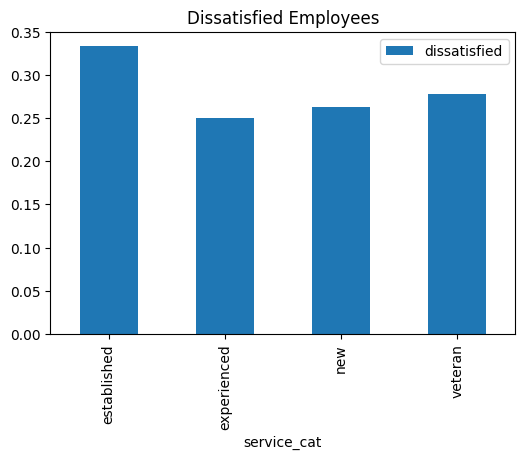

In [223]:
# Plotting results
%matplotlib inline
dis_pivot.plot(kind = 'bar', title = 'Dissatisfied Employees')

The highest percentage of those who were dissatisfied were those who were there for 7-10 years. Although it is only about 10% higher than the other three categories. The other 3 seem fairly evenly distributed, each betwen 25-30%. 